<a href="https://colab.research.google.com/github/Prince-5050/project-it-tmsl/blob/main/PROTIEN_SEQUENCE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Protien Sequence Classification**

In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = 'drive/My Drive/random_split/'
print('Available data', os.listdir(data_path))

Mounted at /content/drive
Available data ['random_split', 'test', 'train', 'dev']


In [ ]:
# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)
# reading all data_partitions

df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

Basic statistics


In [ ]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...
3,Transposase_20,Q981X5_RHILO/224-313,PF02371.16,VEAYQAMRGASFLVAVIFAAEI.GDV.RR.FDTPPQLMAFLGLVPG...,VEAYQAMRGASFLVAVIFAAEIGDVRRFDTPPQLMAFLGLVPGERS...
4,Mycobact_memb,MMPS4_MYCLE/16-154,PF05423.13,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...,LSRIWIPLVILVVLVVGGFVVYRVHSYFASEKRESYADSNLGSSKP...


# **Aligned Sequence**
# Each character reperesents one of the 24(20 common + 4 uncommon) amino acids in the sequence.

In [ ]:
# Given data size
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [ ]:
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))
# Unique classes in the given dataset : [df_train, df_val and df_test]

calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


COUNTING SEQUENCES

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

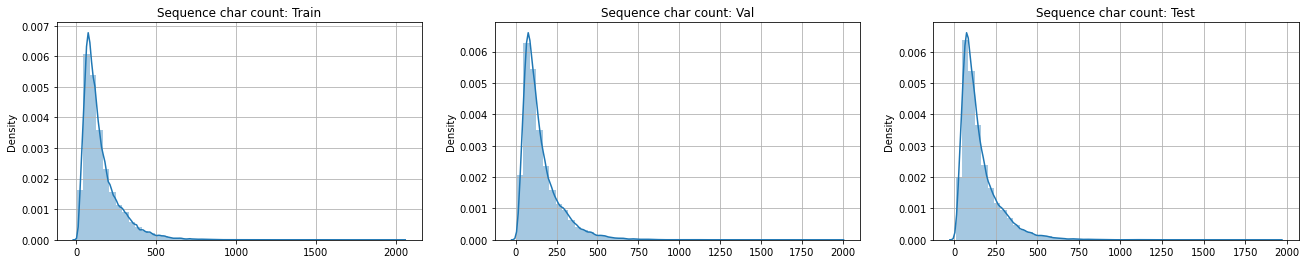

In [ ]:
# Length of sequence in train data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


 **observation** :
 Most of the unaligned amino acids are in the range **0-250**

**SEQUENCE CODE FREQUENCY**:Representing Amino acids with their corresponding 1 letter code.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [ ]:
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 25


,Code,Freq
0,L,17062816
1,A,14384873
2,V,11913147
3,G,11845579
4,E,10859966
5,S,10597822
6,I,10234455
7,R,9406165
8,D,9371097
9,K,9127832


In [ ]:
# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 22


,Code,Freq
0,L,1967025
1,A,1667703
2,V,1382128
3,G,1376124
4,E,1249356
5,S,1210750
6,I,1185722
7,R,1085950
8,D,1080572
9,K,1047638


In [ ]:
# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 24


,Code,Freq
0,L,1967046
1,A,1668137
2,V,1380962
3,G,1375349
4,E,1251000
5,S,1210559
6,I,1184239
7,R,1085786
8,D,1078379
9,K,1045957


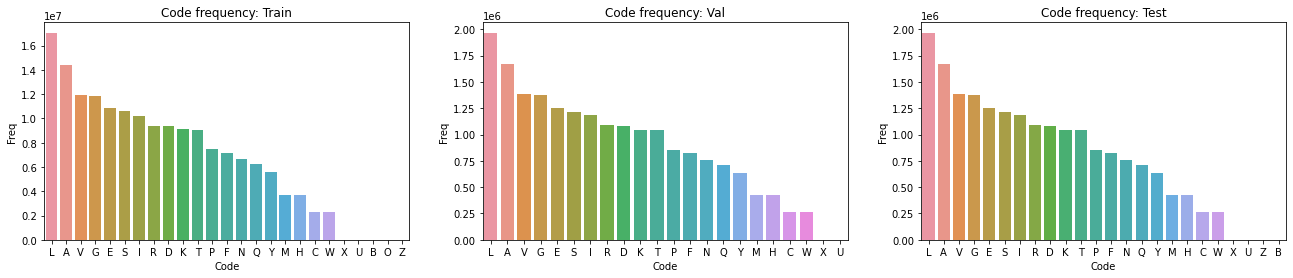

In [ ]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

# **OBSERVATIONS:**

1.   Most frequent amino acid code is L followed by A, V, G.
2.   As we can see that the uncommon amino acids (i.e., X, U, B, O, Z) are present in very less quantity. Therefore we can consider only 20 common natural amino acids for sequence encoding.

## **Protein families with most sequences(No. of observations)**

In [ ]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [ ]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [ ]:
df_test.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

# **OBSERVATIONS:**

1.Top 20 classes are same across all the sets [train, test, val].

2.Test and Val sets have almost same frequency for the top 20 classes.

# **Considering 100 classes based on no. of observations.**

In [ ]:
# Considering top 100 classes based on most observations because of limited computational power.

classes = df_train['family_accession'].value_counts()[:100].index.tolist()
len(classes)

100

In [ ]:
# Filtering data based on considered 100 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 100 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 100 classes for each data split:
Train size : 92983
Val size : 11565
Test size : 11565


In [ ]:
# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Number of unique classes in Train:  100
Number of unique classes in Val:  100
Number of unique classes in Test:  100


## **DEEP LEARNING MODELS:**

Text processing

In [ ]:
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm)

In [ ]:
# padding sequences

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((92983, 100), (11565, 100), (11565, 100))

In [ ]:
# One hot encoding of sequences

train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((92983, 100, 21), (11565, 100, 21), (11565, 100, 21))

In [ ]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((92983,), (11565,), (11565,))

In [ ]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((92983, 100), (11565, 100), (11565, 100))

# **MODEL 1- BIDIRECTIONAL LSTM**

In [ ]:
x_input = Input(shape=(100,))
emb = Embedding(21, 100, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(100, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2100      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84992     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                                 
Total params: 99,992
Trainable params: 99,992
Non-trainable params: 0
_________________________________________________________

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history1 = model1.fit(
    train_pad, y_train,
    epochs=20, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Epoch 1/20
364/364 [==============================] - 14s 18ms/step - loss: 4.9374 - accuracy: 0.1489 - val_loss: 3.3928 - val_accuracy: 0.3251
Epoch 2/20
364/364 [==============================] - 6s 16ms/step - loss: 2.8891 - accuracy: 0.4071 - val_loss: 2.4144 - val_accuracy: 0.5185
Epoch 3/20
364/364 [==============================] - 6s 16ms/step - loss: 2.1484 - accuracy: 0.5770 - val_loss: 1.7887 - val_accuracy: 0.6736
Epoch 4/20
364/364 [==============================] - 6s 16ms/step - loss: 1.6265 - accuracy: 0.7072 - val_loss: 1.3522 - val_accuracy: 0.7872
Epoch 5/20
364/364 [==============================] - 6s 16ms/step - loss: 1.2817 - accuracy: 0.7913 - val_loss: 1.0992 - val_accuracy: 0.8367
Epoch 6/20
364/364 [==============================] - 6s 17ms/step - loss: 1.0734 - accuracy: 0.8350 - val_loss: 0.9149 - val_accuracy: 0.8768
Epoch 7/20
364/364 [==============================] - 6s 17ms/step - loss: 0.9267 - accuracy: 0.8648 - val_loss: 0.7694 - val_accuracy: 0.908

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])


364/364 [==============================] - 3s 8ms/step - loss: 0.3639 - accuracy: 0.9621
Train loss:  0.36387965083122253
Train accuracy:  0.9620683193206787
----------------------------------------------------------------------
46/46 [==============================] - 0s 9ms/step - loss: 0.3739 - accuracy: 0.9585
Val loss:  0.3738696277141571
Val accuracy:  0.9584954380989075
----------------------------------------------------------------------
46/46 [==============================] - 0s 8ms/step - loss: 0.3802 - accuracy: 0.9565
Test loss:  0.38017746806144714
Test accuracy:  0.9565067291259766


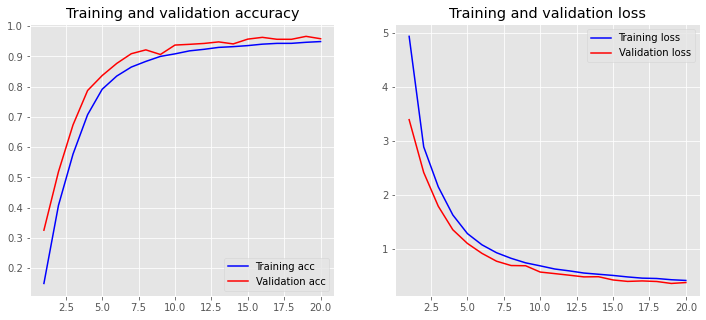

In [ ]:
# Showing the model's results
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

plot_history(history1)


# **MODEL 2- RESNET**

In [ ]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [ ]:
# model

x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(100, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 100, 2)
res2 = residual_block(res1, 100, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(100, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 21)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 100)     2200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100)    400         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 100, 100)     0           ['batch_normalization[0][0]

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history2 = model2.fit(
    train_ohe, y_train,
    epochs=10, batch_size=256,
    validation_data=(val_ohe, y_val),
    callbacks=[es]
    )

Epoch 1/10
364/364 [==============================] - 18s 29ms/step - loss: 0.6884 - accuracy: 0.9324 - val_loss: 0.4083 - val_accuracy: 0.9919
Epoch 2/10
364/364 [==============================] - 9s 25ms/step - loss: 0.2807 - accuracy: 0.9956 - val_loss: 0.2211 - val_accuracy: 0.9966
Epoch 3/10
364/364 [==============================] - 9s 25ms/step - loss: 0.1667 - accuracy: 0.9976 - val_loss: 0.1356 - val_accuracy: 0.9959
Epoch 4/10
364/364 [==============================] - 9s 25ms/step - loss: 0.0984 - accuracy: 0.9983 - val_loss: 0.0841 - val_accuracy: 0.9971
Epoch 5/10
364/364 [==============================] - 9s 25ms/step - loss: 0.0645 - accuracy: 0.9980 - val_loss: 0.0682 - val_accuracy: 0.9954
Epoch 6/10
364/364 [==============================] - 9s 26ms/step - loss: 0.0578 - accuracy: 0.9970 - val_loss: 0.0681 - val_accuracy: 0.9950
Epoch 7/10
364/364 [==============================] - 9s 25ms/step - loss: 0.0618 - accuracy: 0.9959 - val_loss: 0.0823 - val_accuracy: 0.994

364/364 [==============================] - 4s 11ms/step - loss: 0.0669 - accuracy: 0.9992
Train loss:  0.06691739708185196
Train accuracy:  0.9991503953933716
----------------------------------------------------------------------
46/46 [==============================] - 0s 10ms/step - loss: 0.0920 - accuracy: 0.9945
Val loss:  0.09199228137731552
Val accuracy:  0.9944660663604736
----------------------------------------------------------------------
46/46 [==============================] - 0s 10ms/step - loss: 0.0827 - accuracy: 0.9952
Test loss:  0.08268526196479797
Test accuracy:  0.995157778263092


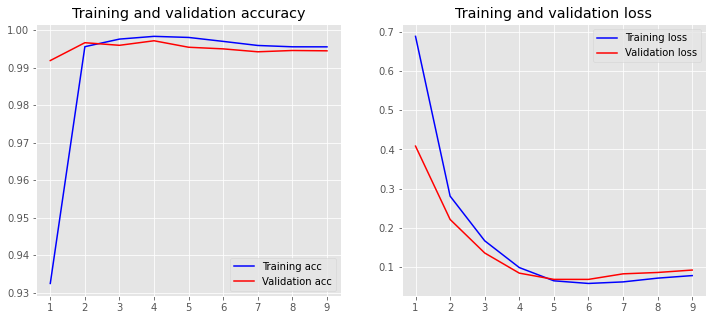

In [ ]:
display_model_score(
    model2,
    [train_ohe, y_train],
    [val_ohe, y_val],
    [test_ohe, y_test],
    256)
plot_history(history2)

# **CONCLUSION:** RESNET performs better than BIDIRECTIONAL LSTM.

In [ ]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Train Acc', 'Val Acc','Test Acc']

x.add_row(['1.', 'Bidirectional LSTM', '0.9721', '0.9678', '0.9671'])
x.add_row(['2.', 'ResNet', '0.9993', '0.9957', '0.9955'])

print(x)

+-------+--------------------+-----------+---------+----------+
| Sr.no |       Model        | Train Acc | Val Acc | Test Acc |
+-------+--------------------+-----------+---------+----------+
|   1.  | Bidirectional LSTM |   0.9721  |  0.9678 |  0.9671  |
|   2.  |       ResNet       |   0.9993  |  0.9957 |  0.9955  |
+-------+--------------------+-----------+---------+----------+
